### Machine-to-Machine (M2M) API:

---

#### Pros:

1. **Same for Manual Download**: The same API we used for downloading data manually can be used for automating the process.

2. **Easy to Use**: The API is easy to use and doesn't require any special setup. Only USGS account and password are required.

---

#### Cons:

1. **Learning Curve**: Need to get familiar with the API and its parameters. e.g. how to find the metal text and the corresponding band files.

2. **Little Technical Support**: The API is not well documented and there is little technical support. Website: "This service is provided "as is" without guarantee of technical assistance."
---

#### How-to:

**Run block by block and remember to change login data"**

In [3]:
import requests
import json

In [26]:
def post_request(endpoint, data, auth_token = None):
    login_url = 'https://m2m.cr.usgs.gov/api/api/json/stable/' + endpoint
    headers = {
        'X-Auth-Token': auth_token
    }
    response = requests.post(login_url, json=data, headers=headers)
    if response.status_code != 200:
        print("Error: " + str(response.status_code))
        return None
    response = response.json()
    formatted_json = json.dumps(response, indent=4)
    return formatted_json

In [16]:

login_data = {
    "username": "TODO",
    "password": "TODO"
}

# Login
api_key = post_request("login", login_data)['data']

if api_key:
    # Perform actions with the obtained API key
    print("Login successful. API Key:", api_key)


Login successful. API Key: eyJjaWQiOjI2OTQxNDg3LCJzIjoiMTY5ODc4MDM4OSIsInIiOjI0MiwicCI6WyJ1c2VyIiwiZG93bmxvYWQiLCJvcmRlciJdfQ==


In [28]:
dataset_id = "5e83d14f2fc39685"
dataset_name = "landsat_ot_c2_l2"
dataset_search_response = post_request("dataset",{"datasetName":dataset_name},api_key)
print(dataset_search_response)

{
    "requestId": 1502634509,
    "version": "stable",
    "sessionId": 249608256,
    "data": {
        "abstractText": "The USGS Earth Resources Observation and Science (EROS) Center archive holds data collected by the Landsat suite of satellites, beginning with Landsat 1 in 1972.  Landsat 8, launched February 11, 2013, is the latest Landsat sensor.",
        "acquisitionStart": "2013-04-11",
        "acquisitionEnd": null,
        "catalogs": [
            "EE"
        ],
        "collectionName": "Landsat 8-9 OLI/TIRS C2 L2",
        "collectionLongName": "Landsat 8-9 Operational Land Imager and Thermal Infrared Sensor Collection 2 Level-2",
        "datasetId": "5e83d14f2fc39685",
        "datasetAlias": "landsat_ot_c2_l2",
        "datasetCategoryName": "Landsat Collection 2 Level-2",
        "dataOwner": "LSAA",
        "dateUpdated": "2023-10-17 12:40:07.907403-05",
        "doiNumber": "https://doi.org/10.5066/P9OGBGM6 ",
        "ingestFrequency": "P1D",
        "keywords": 

In [34]:
scene_data ={
     "maxResults": 5,
    "datasetName": dataset_name,
    "sceneFilter": {
        "spatialFilter": {
            "filterType": "mbr",
            "lowerLeft": {
                "latitude": 40,
                "longitude":  -79
            },
            "upperRight": {
                    "latitude": 50,
                    "longitude": -80
            }
        },
        "metadataFilter": None,
        "cloudCoverFilter": {
            "max": 100,
            "min": 0,
            "includeUnknown": True
        },
    },
    "metadataType": "summary",
}

scene_search_response = post_request("scene-search",scene_data,api_key)
print(scene_search_response)

{
    "requestId": 1502650575,
    "version": "stable",
    "sessionId": 249608256,
    "data": {
        "results": [
            {
                "browse": [
                    {
                        "id": "5fb4ba12d7ec307f",
                        "browseRotationEnabled": null,
                        "browseName": "Level-1 Reflective Browse",
                        "browsePath": "https://landsatlook.usgs.gov/gen-browse?size=rrb&type=refl&product_id=LC09_L1GT_019025_20231030_20231030_02_T2",
                        "overlayPath": "https://landsatlook.usgs.gov/dynamic-tiler/scenes/LC09_L1GT_019025_20231030_20231030_02_T2/tiles/{z}/{x}/{y}.png?layer=natural_color",
                        "overlayType": "ls_chs",
                        "thumbnailPath": "https://landsatlook.usgs.gov/gen-browse?size=thumb&type=refl&product_id=LC09_L1GT_019025_20231030_20231030_02_T2"
                    }
                ],
                "cloudCover": 74,
                "entityId": "LC9019025

In [41]:
entity_id = json.loads(scene_search_response)["data"]["results"][0]["entityId"]
print(entity_id)

LC90190252023303LGN00


In [42]:
# check download options available
download_options = post_request("download-options",{"datasetName":dataset_name,"entityIds":[entity_id]},api_key)
print(download_options)

{
    "requestId": 1502659897,
    "version": "stable",
    "sessionId": 249608256,
    "data": [
        {
            "id": "5e83d14fec7cae84",
            "downloadName": null,
            "displayId": "LC09_L2SP_019025_20231030_20231031_02_T2",
            "entityId": "LC90190252023303LGN00",
            "datasetId": "5e83d14f2fc39685",
            "available": false,
            "filesize": 990051589,
            "productName": "Landsat Collection 2 Level-2 Product Bundle",
            "productCode": "D694",
            "bulkAvailable": false,
            "downloadSystem": "ls_zip",
            "secondaryDownloads": [
                {
                    "id": "5f85f0419985f2aa",
                    "downloadName": null,
                    "displayId": "LC09_L2SP_019025_20231030_20231031_02_T2_ANG.txt",
                    "entityId": "L2ST_LC09_L2SP_019025_20231030_20231031_02_T2_ANG_TXT",
                    "datasetId": "5f85f041c828327a",
                    "available": tru

In [47]:
dataset_download_options_args ={
    "datasetName": dataset_name,
    "sceneFilter": {
        "spatialFilter": {
            "filterType": "mbr",
            "lowerLeft": {
                "latitude": 40,
                "longitude":  -79
            },
            "upperRight": {
                    "latitude": 50,
                    "longitude": -80
            }
        },
        "metadataFilter": None,
        "cloudCoverFilter": {
            "max": 100,
            "min": 0,
            "includeUnknown": True
        },
    },
}
dataset_download_options = post_request("dataset-download-options",dataset_download_options_args,api_key)
print(dataset_download_options)

{
    "requestId": 1502668718,
    "version": "stable",
    "sessionId": 249608256,
    "data": [
        {
            "productId": "5e83d14fec7cae84",
            "productCode": "D694",
            "productName": "Landsat Collection 2 Level-2 Product Bundle",
            "downloadName": null,
            "downloadSystem": "ls_zip",
            "fileGroups": null,
            "numScenes": 4964,
            "estFilesize": "4714118573756"
        },
        {
            "productId": "632210d4770592cf",
            "productCode": "D806",
            "productName": "Landsat Collection 2 Level-2 Product Bundle",
            "downloadName": null,
            "downloadSystem": "dds",
            "fileGroups": null,
            "numScenes": 902,
            "estFilesize": "860358983136"
        },
        {
            "productId": "6448198cc7b442a4",
            "productCode": "D693",
            "productName": "Landsat Collection 2 Level-2 Band File",
            "downloadName": "C2L2 Tile

In [58]:
download_args = {
    "downloads": [
        {
            "entityId": json.loads(download_options)["data"][0]["secondaryDownloads"][6]["entityId"],
            "productId": json.loads(download_options)["data"][0]["secondaryDownloads"][6]["id"],
        }
    ],
}

download = post_request("download-request",download_args,api_key)
print(download)

{
    "requestId": 1502680872,
    "version": "stable",
    "sessionId": 249608256,
    "data": {
        "availableDownloads": [
            {
                "downloadId": 492246882,
                "eulaCode": null,
                "url": "https://dds.cr.usgs.gov/download/eyJpZCI6NDkyMjQ2ODgyLCJjb250YWN0SWQiOjI2OTQxNDg3fQ=="
            }
        ],
        "duplicateProducts": {
            "492246882": "m2m_1502680691_20231031153234"
        },
        "preparingDownloads": [],
        "failed": [],
        "newRecords": [],
        "numInvalidScenes": 0
    },
    "errorCode": null,
    "errorMessage": null
}


In [59]:
# Parse the JSON data
download_data = json.loads(download)

# Extract the download URL
download_url = download_data['data']['availableDownloads'][0]['url']

# Save the file to your laptop
response = requests.get(download_url)
if response.status_code == 200:
    with open('test.TIF', 'wb') as file:
        file.write(response.content)
    print("File saved to 'test.TIF'")
else:
    print("Failed to download the file.")

File saved to 'downloaded_file.zip'


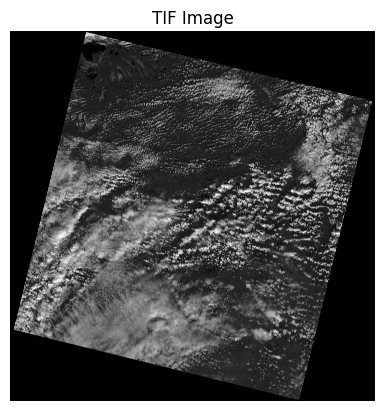

In [60]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Assuming you have saved the .tif file as 'downloaded_file.tif'
image_path = 'test.tif'

# Load and display the image
image = imread(image_path)
plt.imshow(image, cmap='gray')  # 'cmap' specifies the color map, you can change it as needed
plt.axis('off')  # Turn off axis labels
plt.title('TIF Image')
plt.show()
